## Data preparation and sanitization

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sb

from core.utils.preprocessing import df_to_xy

RND_SEED = 6
np.random.seed = RND_SEED

TREATMENT = "t00"

# Read and sanitize the data
df = pd.read_csv(f"../data/{TREATMENT}/export/result__{TREATMENT}_prop.csv")
df_full = df.copy()
drop_cols = ["worker_id", "resp_worker_id", "prop_worker_id", "updated", "status", "job_id", "status", "timestamp", "rowid", "offer_dss", "offer", "offer_final", "completion_code"]
df = df[[col for col in df.columns if col not in drop_cols]]
df = df.dropna()


x, y = df_to_xy(df, fuse_risk=False, centered=False)

## Linear regression (continuous dataset)

**Accuracy / Loss - For model comparison**

In [2]:
from core.models.metrics import MAX_GAIN


#### Benchmark

In [3]:
from core.utils.benchmark import process_benchmarks, process_benchmark_cv, process_model


**Keras Model**

In [4]:
from core.models.deep import KerasModel, loss_tf, gain_tf

Using TensorFlow backend.


In [5]:
import os, sys


**Featureless model**

In [7]:
from core.models import EMModel, RandomModel

**Convervative model**

In [8]:
from core.models import ConservativeModel

**Linear/Logistic regression**

In [9]:
from sklearn.linear_model import LinearRegression, LogisticRegression

**Random**

**Random Forest**

In [11]:
from sklearn.ensemble.forest import RandomForestClassifier, RandomForestRegressor

**Clustering**

In [12]:
from core.models import ClusterModel, ClusterExtModel

In [13]:
from sklearn.neural_network import MLPClassifier

** Acceptance model **

In [14]:
from core.models import AcceptanceModel

** Data augmentation **

In [15]:
from core.utils.data_augmentation import DACombine

**Baseline models**

In [16]:
from sklearn.svm import SVC

benchmark_models = {
    #Featureless:
    "random": RandomModel(MAX_GAIN),
    "conservative": ConservativeModel(MAX_GAIN),
    "em": EMModel(MAX_GAIN),
    "svc": SVC(gamma='auto'),
    "linear_regressor": LinearRegression(copy_X=False),
#     "linear_regressor_mse": keras_linear_regression(loss="mse"),
}

results = dict()
# for key, model in benchmark_models.items():
#     results[key] = process_benchmark_cv(model, x, y.ravel())
#     results[key+"_da"] = process_benchmark_cv(model, x, y.ravel(), augment_data=2)
#results = {key: process_benchmark_cv(model, x, y.ravel()) for key, model in benchmark_models.items()}
results = process_benchmarks(benchmark_models, x, y.ravel(), augment_data=[None])

results_mean = {key: item.mean() for key, item in results.items()}
results_std = {key: item.std() for key, item in results.items()}
results_df = pd.DataFrame(results_mean).T
results_df.sort_values("avg_loss_ratio", inplace=True)
results_df

,avg_loss,avg_loss_ratio,avg_win_loss,invariance,loss_sum,mse,rejection_ratio
em,11.771429,0.187675,11.537176,1.000000,242.000000,386.095238,0.049048
svc,11.771429,0.187675,11.537176,1.000000,242.000000,386.095238,0.049048
random,32.911212,0.613098,19.251166,0.195018,677.595947,1483.780237,0.467143
linear_regressor,42.320793,0.739311,34.335815,0.152042,871.976648,2250.104788,0.457143
conservative,54.466667,0.916466,56.149749,1.000000,1122.000000,3288.595238,0.029524


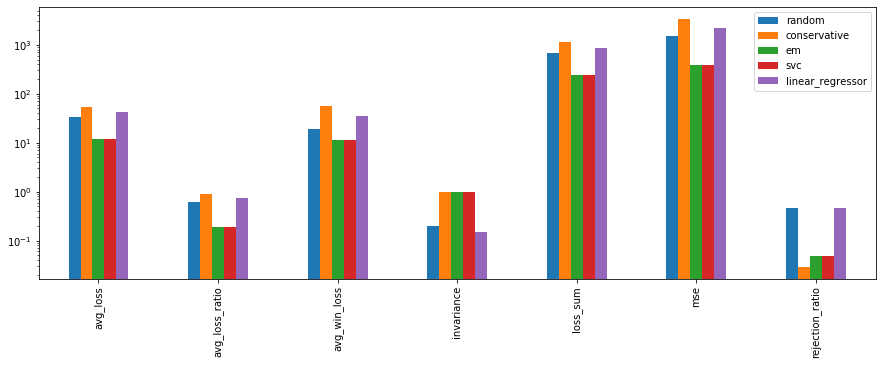

In [17]:
df_results_mean = pd.DataFrame(results_mean)
df_results_std = pd.DataFrame(results_std)
df_results_mean.plot.bar(logy=True, figsize=(15, 5))

**Clustering based models**

In [18]:
benchmark_models = {
#     #Cluster-based
    "affinity": ClusterModel(base_model="affinity"),
#     "bayes": ClusterModel(base_model="bayes", n_components=8),
#     "birch": ClusterModel(base_model="birch"),
#     "kmeans": ClusterModel(base_model="kmeans", n_clusters=16),
    "meanshift": ClusterModel(base_model="meanshift", cluster_all=True),
    "affinity_ext": ClusterExtModel(base_model="affinity"),
#     "bayes_ext": ClusterExtModel(base_model="bayes", n_components=8),
#     "birch_ext": ClusterExtModel(base_model="birch"),
#     "kmeans_ext": ClusterModel(base_model="kmeans", n_clusters=16),
    "meanshift_ext": ClusterExtModel(base_model="meanshift", cluster_all=True),
}

# results = {key: process_benchmark_cv(model, x, y.ravel(), ) for key, model in benchmark_models.items()}
results = process_benchmarks(benchmark_models, x, y.ravel(), augment_data=[None], shuffle=True)

results_mean = {key: item.mean() for key, item in results.items()}
results_std = {key: item.std() for key, item in results.items()}
results_df = pd.DataFrame(results_mean).T
results_df.sort_values("avg_loss_ratio", inplace=True)
results_df

,avg_loss,avg_loss_ratio,avg_win_loss,invariance,loss_sum,mse,rejection_ratio
meanshift_ext,11.802381,0.187098,11.585213,1.000000,242.0,387.226190,0.048095
affinity_ext,13.042857,0.209049,12.544737,0.639074,268.0,441.095238,0.057619
meanshift,19.702381,0.319851,19.940476,1.000000,404.4,636.397619,0.038095
affinity,23.803810,0.412772,18.995816,0.282162,491.4,984.514286,0.210952


In [19]:
pd.DataFrame(results_std).T

,avg_loss,avg_loss_ratio,avg_win_loss,invariance,loss_sum,mse,rejection_ratio
affinity,8.532688,0.145904,3.717548,0.059061,181.491873,413.585348,0.158629
meanshift,5.349545,0.031181,4.836909,0.000000,102.441691,293.451550,0.062088
affinity_ext,4.606763,0.081225,4.614780,0.336278,90.318880,208.848405,0.052066
meanshift_ext,5.057336,0.075938,4.575046,0.000000,98.526646,228.580689,0.058331


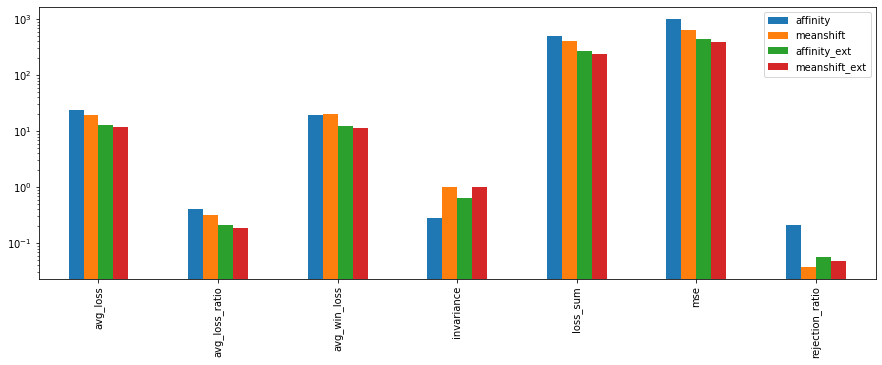

In [20]:
df_results_mean = pd.DataFrame(results_mean)
df_results_std = pd.DataFrame(results_std)
df_results_mean.plot.bar(logy=True, figsize=(15, 5))

**Other models**

In [21]:
# benchmark_models = {
#     'em': EMModel(),
#     # Regression
#     #"random_forest_regr": RandomForestRegressor(min_samples_leaf=5),
#     'logistic_regression': LogisticRegression(penalty='l1', solver='liblinear', multi_class='auto'),
#     "nn": KerasModel(no_hidden_layer=True),
# #     "nn_regression": KerasModel(batch_size=30, epochs=200),
#     'acceptance_model': AcceptanceModel(),   #step=10, zero_one=True),
#     # Classification
#     "random_forest": RandomForestClassifier(min_samples_leaf=5),#max_depth=3, random_state=0, n_estimators=10),
# }

# results = dict()

# results = process_benchmarks(benchmark_models, x, y.ravel(), augment_data=[None, 2])

# results_mean = {key: item.mean() for key, item in results.items()}
# results_std = {key: item.std() for key, item in results.items()}
# results_df = pd.DataFrame(results_mean).T
# results_df.sort_values("avg_loss_ratio", inplace=True)
# results_df

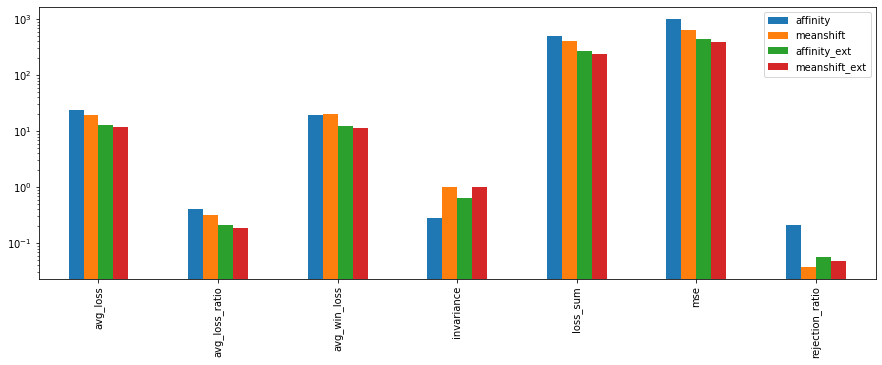

In [22]:
df_results_mean = pd.DataFrame(results_mean)
df_results_std = pd.DataFrame(results_std)
df_results_mean.plot.bar(logy=True, figsize=(15, 5))

**TOP MODELS**

In [23]:
# from sklearn.svm import SVR
# benchmark_models = {
#     'em': EMModel(),
#     'logistic_regression': LogisticRegression(penalty='l1', solver='liblinear', multi_class='auto'),
#     'svc': SVC(gamma='auto'),
#     'acceptance_model': AcceptanceModel(step=10, zero_one=True),
#     'acceptance_model_svr': AcceptanceModel(SVR(gamma='auto', kernel='poly', degree=1), step=10, zero_one=True),
    
#     # Classification
#     #"random_forest": RandomForestClassifier(min_samples_leaf=5),#max_depth=3, random_state=0, n_estimators=10),
# }

# results = dict()

# results = process_benchmarks(benchmark_models, x, y.ravel(), augment_data=None)

# results_mean = {key: item.mean() for key, item in results.items()}
# results_std = {key: item.std() for key, item in results.items()}
# results_df = pd.DataFrame(results_mean).T
# results_df.sort_values("avg_loss_ratio", inplace=True)
# results_df

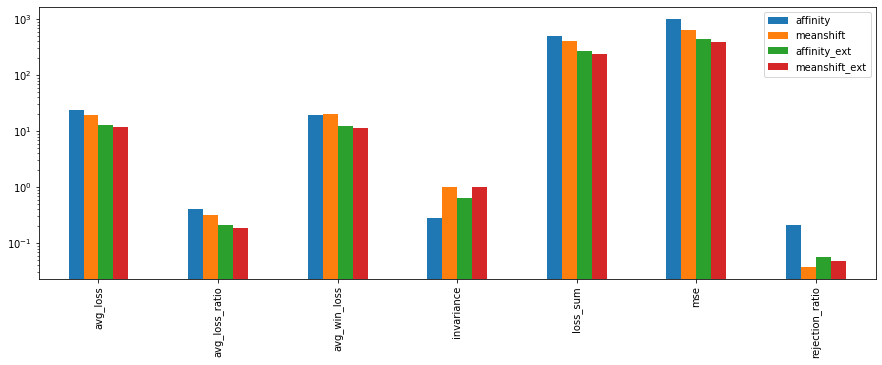

In [24]:
df_results_mean = pd.DataFrame(results_mean)
df_results_std = pd.DataFrame(results_std)
df_results_mean.plot.bar(logy=True, figsize=(15, 5))

In [25]:
# from sklearn.svm import SVR
# benchmark_models = {
#     'mlp': MLPClassifier(
#         hidden_layer_sizes=(1024,), max_iter=1024, solver='sgd',
#         learning_rate='adaptive',
#         activation='relu',
#     ),
#     'log_reg': LogisticRegression(multi_class='auto', solver='lbfgs'),
# }

# results = dict()

# results = process_benchmarks(benchmark_models, x, y.ravel(), augment_data=None)

# results_mean = {key: item.mean() for key, item in results.items()}
# results_std = {key: item.std() for key, item in results.items()}
# results_df = pd.DataFrame(results_mean).T
# results_df.sort_values("avg_loss_ratio", inplace=True)
# results_df

In [26]:
from core.models.metrics import avg_gain_ratio
clf = ClusterExtModel(base_model="meanshift")
xTrain, xTest, yTrain, yTest = train_test_split(x, y)
clf.fit(xTrain, yTrain)

# clf = EMModel()
xTrain, xTest, yTrain, yTest = train_test_split(x, y)
clf.fit(xTrain, yTrain)

yPred = clf.predict(xTrain)

print(np.unique(yPred))

print("acc: ", avg_gain_ratio(yTrain, yPred))
yPred = clf.predict(xTest)
print(np.unique(yPred))
print("val_acc: ", avg_gain_ratio(yTest, yPred))

[50.]
acc:  0.8171524267127579
[50.]
val_acc:  0.8007252531544029


In [27]:
benchmark_models = {
    #Featureless:
    "random": RandomModel(MAX_GAIN),
    "conservative": ConservativeModel(MAX_GAIN),
    "em": EMModel(MAX_GAIN),
    "svc": SVC(gamma='auto'),
    "cluster-meanshift": ClusterExtModel(base_model="meanshift"),
    "linear_regressor": LinearRegression(copy_X=False),
    "nn": KerasModel(no_hidden_layer=False, epochs=500),
#     "nn_regression": KerasModel(batch_size=30, epochs=200),
    'acceptance_model': AcceptanceModel(SVC(gamma='auto')),   #step=10, zero_one=True),
    # Classification
    "random_forest": RandomForestClassifier(min_samples_leaf=5),#max_depth=3, random_state=0, n_estimators=10),
}

results = dict()

results = process_benchmarks(benchmark_models, x, y.ravel(), augment_data=[None])

results_mean = {key: item.mean() for key, item in results.items()}
results_std = {key: item.std() for key, item in results.items()}
results_df = pd.DataFrame(results_mean).T
results_df.sort_values("avg_loss_ratio", inplace=True)
results_df

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20

,avg_loss,avg_loss_ratio,avg_win_loss,invariance,loss_sum,mse,rejection_ratio
em,11.771429,0.187675,11.537176,1.000000,242.000000,386.095238,0.049048
svc,11.771429,0.187675,11.537176,1.000000,242.000000,386.095238,0.049048
cluster-meanshift,11.771429,0.187675,11.537176,1.000000,242.000000,386.095238,0.049048
random_forest,14.404762,0.242525,11.871596,0.495441,296.000000,515.904762,0.107619
random,36.349643,0.659751,22.425838,0.192168,747.912511,1761.290669,0.506190
acceptance_model,38.166667,0.706664,16.913781,0.231395,787.000000,1921.880952,0.640476
linear_regressor,42.320793,0.739311,34.335815,0.152042,871.976648,2250.104788,0.457143
conservative,54.466667,0.916466,56.149749,1.000000,1122.000000,3288.595238,0.029524
nn,70.657806,2.762896,71.288667,0.135331,1458.395067,7297.358836,0.009524


In [28]:
results_df = results_df[[col for col in results_df.columns if col not in ["loss_sum", "mse"]]]

print(results_df.to_latex(float_format="%.2f"))

\begin{tabular}{lrrrrr}
\toprule
{} &  avg\_loss &  avg\_loss\_ratio &  avg\_win\_loss &  invariance &  rejection\_ratio \\
\midrule
em                &     11.77 &            0.19 &         11.54 &        1.00 &             0.05 \\
svc               &     11.77 &            0.19 &         11.54 &        1.00 &             0.05 \\
cluster-meanshift &     11.77 &            0.19 &         11.54 &        1.00 &             0.05 \\
random\_forest     &     14.40 &            0.24 &         11.87 &        0.50 &             0.11 \\
random            &     36.35 &            0.66 &         22.43 &        0.19 &             0.51 \\
acceptance\_model  &     38.17 &            0.71 &         16.91 &        0.23 &             0.64 \\
linear\_regressor  &     42.32 &            0.74 &         34.34 &        0.15 &             0.46 \\
conservative      &     54.47 &            0.92 &         56.15 &        1.00 &             0.03 \\
nn                &     70.66 &            2.76 &         71.29 